# **DATA255 Group3**

## Libraries

In [ ]:
import os
import sys
import random
from glob import glob

import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import statistics as stats
from tabulate import tabulate
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="pyspark")

!pip3 install pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, StructType, StructField, StringType
from pyspark.sql.functions import explode, col, from_json, year, concat_ws
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
import ast

In [ ]:
# Configure Spark

conf = SparkConf().set("spark.executor.memory", "8G")


In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("MovieRecommendation").getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

23/12/06 10:54:37 WARN Utils: Your hostname, Sais-Laptop.local resolves to a loopback address: 127.0.0.1; using 10.0.0.173 instead (on interface en0)
23/12/06 10:54:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/06 10:54:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/06 10:54:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Data Loading

In [ ]:
# Load datasets
movies_metadata = spark.read.csv("movies_metadata.csv", header=True, inferSchema=True)
keywords = spark.read.csv("keywords.csv", header=True, inferSchema=True)
credits = spark.read.csv("credits.csv", header=True, inferSchema=True)
ratings = spark.read.csv("ratings.csv", header=True, inferSchema=True)
links = spark.read.csv("links.csv", header=True, inferSchema=True)
links_small = spark.read.csv("links_small.csv", header=True, inferSchema=True)
ratings_small = spark.read.csv("ratings_small.csv", header=True, inferSchema=True)

## Data Preview

In [ ]:
def display_csv_info_spark(file, file_name):
    print(f"\nFile: {file_name}")

    # Display the first 5 rows
    print("First 5 rows:")
    file.show(5, truncate=False)

    # Print the dimensions (number of rows and columns)
    rows, columns = file.count(), len(file.columns)
    print(f"\nNumber of rows: {rows}")
    print(f"Number of columns: {columns}")

    # Print all column names
    print("\nColumn Names:")
    for column_name in file.columns:
        print(column_name)

#### movies_metadata.csv: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

In [ ]:
display_csv_info_spark(movies_metadata, "movies_metadata.csv")


File: movies_metadata.csv
First 5 rows:


+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+-------------------------------------------------------------------------------------------------+------------------------------------+-----+---------+-----------------+---------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------------------------+-----------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------


Number of rows: 45572
Number of columns: 24

Column Names:
adult
belongs_to_collection
budget
genres
homepage
id
imdb_id
original_language
original_title
overview
popularity
poster_path
production_companies
production_countries
release_date
revenue
runtime
spoken_languages
status
tagline
title
video
vote_average
vote_count


#### keywords.csv: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

In [ ]:
display_csv_info_spark(keywords, 'keywords.csv')


File: keywords.csv
First 5 rows:
+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id   |keywords                                                                                                                                                                                                                                                                                                                                              |
+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### credits.csv: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.¶

In [ ]:
display_csv_info_spark(credits, 'credits.csv')


File: credits.csv
First 5 rows:
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Number of rows: 45476
Number of columns: 3

Column Names:
cast
crew
id


#### links.csv: The file that contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.

In [ ]:
display_csv_info_spark(links, 'links.csv')


File: links.csv
First 5 rows:
+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|1      |114709|862   |
|2      |113497|8844  |
|3      |113228|15602 |
|4      |114885|31357 |
|5      |113041|11862 |
+-------+------+------+
only showing top 5 rows


Number of rows: 45843
Number of columns: 3

Column Names:
movieId
imdbId
tmdbId


#### ratings.csv: The file that contains 2602480 ratings from from 270,000 users on all the 45,000 movies

In [ ]:
display_csv_info_spark(ratings, 'ratings.csv')


File: ratings.csv
First 5 rows:
+------+-------+------+----------+
|userId|movieId|rating|timestamp |
+------+-------+------+----------+
|1     |110    |1.0   |1425941529|
|1     |147    |4.5   |1425942435|
|1     |858    |5.0   |1425941523|
|1     |1221   |5.0   |1425941546|
|1     |1246   |5.0   |1425941556|
+------+-------+------+----------+
only showing top 5 rows




Number of rows: 26024289
Number of columns: 4

Column Names:
userId
movieId
rating
timestamp


#### links_small.csv: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.

In [ ]:
display_csv_info_spark(links_small, 'links_small.csv')


File: links_small.csv
First 5 rows:
+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|1      |114709|862   |
|2      |113497|8844  |
|3      |113228|15602 |
|4      |114885|31357 |
|5      |113041|11862 |
+-------+------+------+
only showing top 5 rows


Number of rows: 9125
Number of columns: 3

Column Names:
movieId
imdbId
tmdbId


#### ratings_small.csv: The subset of 100,000 ratings from 700 users on 9,000 movies.

In [ ]:
display_csv_info_spark(ratings_small, 'ratings_small.csv')


File: ratings_small.csv
First 5 rows:
+------+-------+------+----------+
|userId|movieId|rating|timestamp |
+------+-------+------+----------+
|1     |31     |2.5   |1260759144|
|1     |1029   |3.0   |1260759179|
|1     |1061   |3.0   |1260759182|
|1     |1129   |2.0   |1260759185|
|1     |1172   |4.0   |1260759205|
+------+-------+------+----------+
only showing top 5 rows


Number of rows: 100004
Number of columns: 4

Column Names:
userId
movieId
rating
timestamp


## Merge Relevant Data: assuming movieID is the common identifier in links and rating, merge them

In [ ]:
merged_data = ratings.join(links, "movieId").join(movies_metadata, ratings["movieId"] == movies_metadata["id"])

#### In PySpark, the truncate parameter in the show method determines whether the displayed strings should be truncated or not. When truncate is set to True (default), the strings in the DataFrame's columns will be truncated to fit the console width, making the output more readable. If set to False, the full content of the strings will be displayed.

In [ ]:
# Convert stringified JSON objects: assuming keywords and cast are the relevant columns in keywords.csv and credits.csv
keywords = keywords.withColumn("keywords", from_json("keywords", StructType().add("keywords", StringType())))
credits = credits.withColumn("cast", from_json("cast", StructType().add("cast", StringType())))

## Data Preprocesing

### Handle missing data and abnormal data

In [ ]:
# Get rid of missing data
merged_data = merged_data.na.drop()
merged_data.show()

+-------+------+------+----------+------+------+-----+---------------------+--------+--------------------+--------------------+---+---------+-----------------+--------------+--------------------+----------+--------------------+--------------------+--------------------+------------+--------+-------+--------------------+--------+--------------------+------------+-----+------------+----------+
|movieId|userId|rating| timestamp|imdbId|tmdbId|adult|belongs_to_collection|  budget|              genres|            homepage| id|  imdb_id|original_language|original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date| revenue|runtime|    spoken_languages|  status|             tagline|       title|video|vote_average|vote_count|
+-------+------+------+----------+------+------+-----+---------------------+--------+--------------------+--------------------+---+---------+-----------------+--------------+--------------------+----------+------

In [ ]:
# Dimension after missing data dropped
d_rows, d_columns = merged_data.count(), len(merged_data.columns)
print(f"\nNumber of rows: {d_rows}")
print(f"Number of columns: {d_columns}")


Number of rows: 757109
Number of columns: 30


In [ ]:
# Filter weird rows
merged_data_DOE = merged_data.filter(col("vote_count").cast("int").isNotNull())
merged_data_DOE = merged_data.filter(col("rating").cast("float").isNotNull())
merged_data.show(5)

+-------+------+------+---------+------+------+-----+---------------------+--------+--------------------+--------------------+---+---------+-----------------+--------------+--------------------+----------+--------------------+--------------------+--------------------+------------+--------+-------+--------------------+--------+--------------------+------------+-----+------------+----------+
|movieId|userId|rating|timestamp|imdbId|tmdbId|adult|belongs_to_collection|  budget|              genres|            homepage| id|  imdb_id|original_language|original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date| revenue|runtime|    spoken_languages|  status|             tagline|       title|video|vote_average|vote_count|
+-------+------+------+---------+------+------+-----+---------------------+--------+--------------------+--------------------+---+---------+-----------------+--------------+--------------------+----------+---------

In [ ]:
# Some wrangling
# Remove the features that are not so important to this project
movies_metadata = movies_metadata.drop('imdb_id')

In [ ]:
# Check if the movie is a foreigh lang film (compare title and original_title)
movies_metadata[movies_metadata['original_title'] != movies_metadata['title']][['title', 'original_title']].show()

+--------------------+--------------------+
|               title|      original_title|
+--------------------+--------------------+
|[{'iso_639_1': 'e...|   Waiting to Exhale|
|               105.0|          Get Shorty|
| {'name': 'Victoi...|La Cité des Enfan...|
|      Shanghai Triad|  摇啊摇，摇到外婆桥|
|    Wings of Courage|Guillaumet, les a...|
|[{'iso_639_1': 'e...|     Dead Presidents|
|[{'iso_639_1': 'e...|               Se7en|
|         The Postman|          Il postino|
|    The Confessional|    Le confessionnal|
|Bud and Doyle are...|            Bio-Dome|
|        French Twist|        Gazon maudit|
|      Les Miserables|      Les misérables|
|                   0|           The Juror|
|   The White Balloon|         بادکنک سفید|
|      Antonia's Line|             Antonia|
|               108.0|Last Summer in th...|
|               112.0|     Beautiful Girls|
|                    |Heidi Fleiss: Hol...|
|     Nobody Loves Me|   Keiner liebt mich|
| Rumble in the Bronx|              紅番區|


In [ ]:
# yes and so we don't need original_title column, drop it
movies_metadata = movies_metadata.drop('original_title')

In [ ]:
# Notice that there are a lot of movies having revenue as 0 = no known information about this
# replace them with NA
from pyspark.sql.functions import when
movies_metadata = movies_metadata.withColumn('revenue', when(movies_metadata['revenue'] == 0, None).otherwise(movies_metadata['revenue']))

In [ ]:
# Notice that the budget column also contains werid values
# convert all to numeric and replace all non-numeric values with NA
# 0's also converts to NA

# Convert 'budget' column to numeric with errors='coerce'
movies_metadata = movies_metadata.withColumn('budget', movies_metadata['budget'].cast('double'))

# Replace 0 with None (equivalent to np.nan)
movies_metadata = movies_metadata.withColumn('budget', when(col('budget') == 0, None).otherwise(col('budget')))

# Count the number of rows where 'budget' is null
count_null_budget = movies_metadata.filter(col('budget').isNull()).count()

# Show the count
print(count_null_budget)

36711


In [ ]:
# Also there are two features that need some cleaning: year and return
# year: the year in which the movie got released
# return: the ratrio of revenue to budget (if needed)

# Add 'return' column
movies_metadata = movies_metadata.withColumn('return', col('revenue') / col('budget'))

# Count the number of rows where 'return' is null
count_null_return = movies_metadata.filter(col('return').isNull()).count()

# Show the count
print(count_null_return)

40583


In [ ]:
# Convert 'release_date' to date type and extract the year
from pyspark.sql.functions import col, to_date, year
movies_metadata = movies_metadata.withColumn('release_date', to_date(col('release_date'), 'yyyy-MM-dd'))
movies_metadata = movies_metadata.withColumn('year', year('release_date'))

# Show the updated DataFrame
movies_metadata.show()

+-----+---------------------+---------+--------------------+--------------------+-----+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------+--------------------+-----------------+-------------------+----+
|adult|belongs_to_collection|   budget|              genres|            homepage|   id|original_language|            overview|popularity|         poster_path|production_companies|production_countries|release_date|             revenue|             runtime|    spoken_languages|  status|             tagline|               title|   video|        vote_average|       vote_count|             return|year|
+-----+---------------------+---------+--------------------+--------------------+-----+-----------------+--------------------+----------+--------------------+--------------------+-------------------

### Explore data structures

In [ ]:
# Display the data types of each column
print("Data Types of Columns:")
merged_data.printSchema()

Data Types of Columns:
root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)
 |-- adult: string (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- spoke

## EDA on the merged data

### What are the ratings distributions?

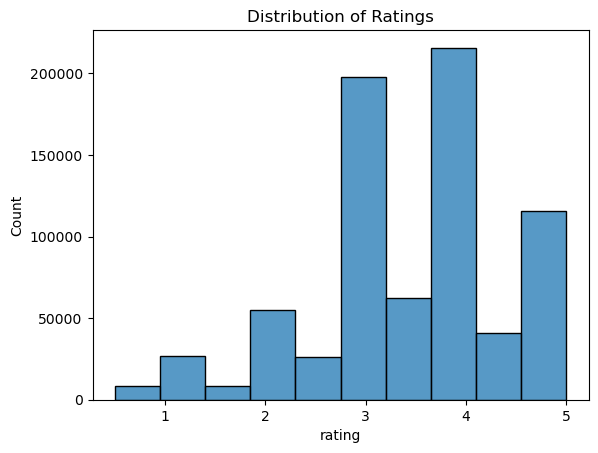

In [ ]:
# EDA on ratings using Pandas DataFrame
ratings_pd = merged_data.select("rating").toPandas()

# Plot distribution of ratings
sns.histplot(ratings_pd["rating"], bins=10)
plt.title("Distribution of Ratings")
plt.show()

In [ ]:
# EDA on ratings using Pandas DataFrame
ratings_pd = merged_data.select("rating").toPandas()

# Create a frequency table (cross-tabulation)
rating_distribution_table = pd.crosstab(index=ratings_pd["rating"], columns="Count")

# Display the table
print("Distribution of Ratings:")
print(rating_distribution_table)

Distribution of Ratings:
col_0    Count
rating        
0.5       8171
1.0      26942
1.5       8393
2.0      55117
2.5      26006
3.0     197587
3.5      62222
4.0     215736
4.5      41057
5.0     115878


### Which are the top 10 movie genres?

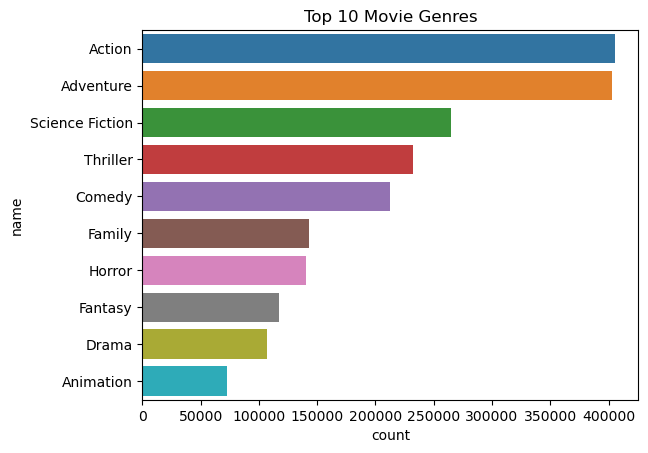

In [ ]:
# Define the schema for genres
genres_schema = ArrayType(StructType([
    StructField("id", StringType()),
    StructField("name", StringType())
]))

# Apply from_json to parse the stringified JSON into the array of structs
topmovies = merged_data.withColumn("genres", from_json(col("genres"), genres_schema))

# Explode the genres column
exploded_data = topmovies.select("movieId", "userId", "rating", "timestamp", explode("genres").alias("genre"))

# EDA on genres
genres_count = exploded_data.groupBy("genre.name").count().orderBy("count", ascending=False).limit(10)

# Convert to Pandas DataFrame for plotting
genres_pd = genres_count.toPandas()

# Plot the bar chart
sns.barplot(x="count", y=genres_pd["name"], data=genres_pd)
plt.title("Top 10 Movie Genres")
plt.show()

### Who are the top 10 users that gave the most ratings?

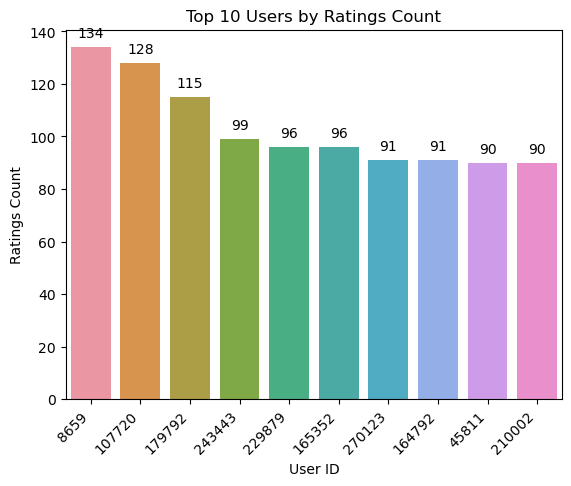

In [ ]:
sns.color_palette("muted")

# EDA on ratings by user
user_ratings_count = merged_data.groupBy("userId").count().orderBy("count", ascending=False).limit(10)

# Convert to Pandas DataFrame for plotting
user_ratings_pd = user_ratings_count.toPandas()

# Use Seaborn color palette
sns.set_palette("Blues_d")

# Plot the bar chart with bars in descending order and rotated x-axis ticks
ax = sns.barplot(x=user_ratings_pd["userId"], y=user_ratings_pd["count"], order=user_ratings_pd.sort_values('count', ascending=False)['userId'])
plt.title("Top 10 Users by Ratings Count")
plt.xlabel("User ID")
plt.ylabel("Ratings Count")

# Rotate x-axis ticks to 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add y-values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

### What are the numbers of movies released each year?

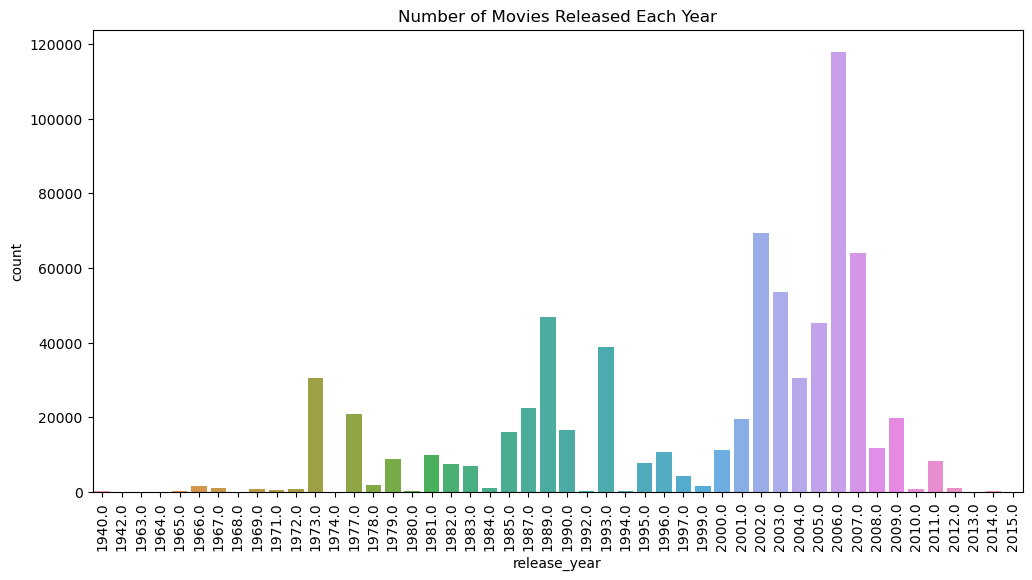

In [ ]:
# Extract the release year from the 'release_date' column
released_year = merged_data.withColumn("release_year", year("release_date"))

# EDA on release year
release_year_count = released_year.groupBy("release_year").count().orderBy("release_year")

# Convert to Pandas DataFrame for plotting
release_year_pd = release_year_count.toPandas()

# Plot the bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="release_year", y="count", data=release_year_pd)
plt.title("Number of Movies Released Each Year")
plt.xticks(rotation=90)

plt.show()

### What are the top 10 genres by average rating?

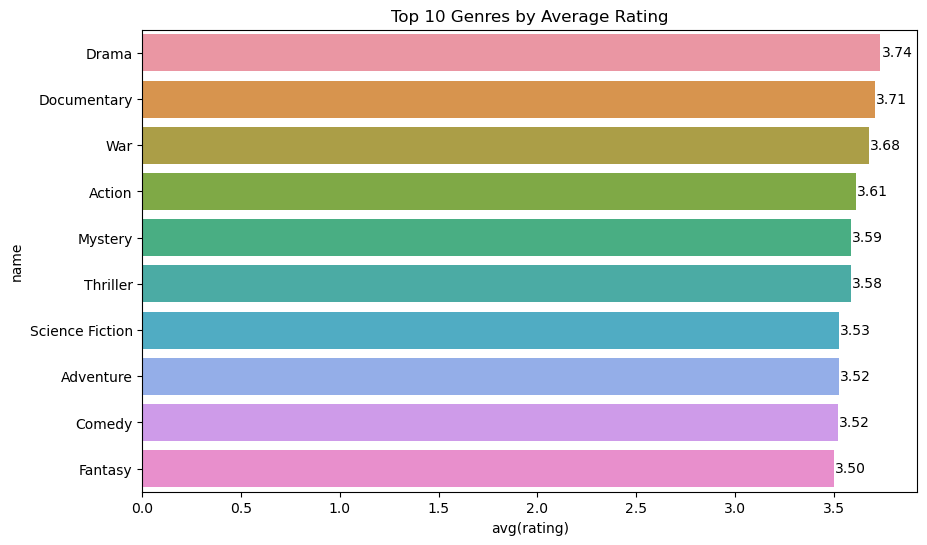

In [ ]:
# EDA on average rating by genre
average_rating_by_genre = exploded_data.groupBy("genre.name").avg("rating").orderBy("avg(rating)", ascending=False).limit(10)

# Convert to Pandas DataFrame for plotting
average_rating_by_genre_pd = average_rating_by_genre.toPandas()

# Plot the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="avg(rating)", y=average_rating_by_genre_pd["name"], data=average_rating_by_genre_pd)
plt.title("Top 10 Genres by Average Rating")

# Add bar values on top of the bars with adjusted position
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='center', va='center', xytext=(12, 0), textcoords='offset points', color='black')

plt.show()

### What are the top 10 highest rated movies?

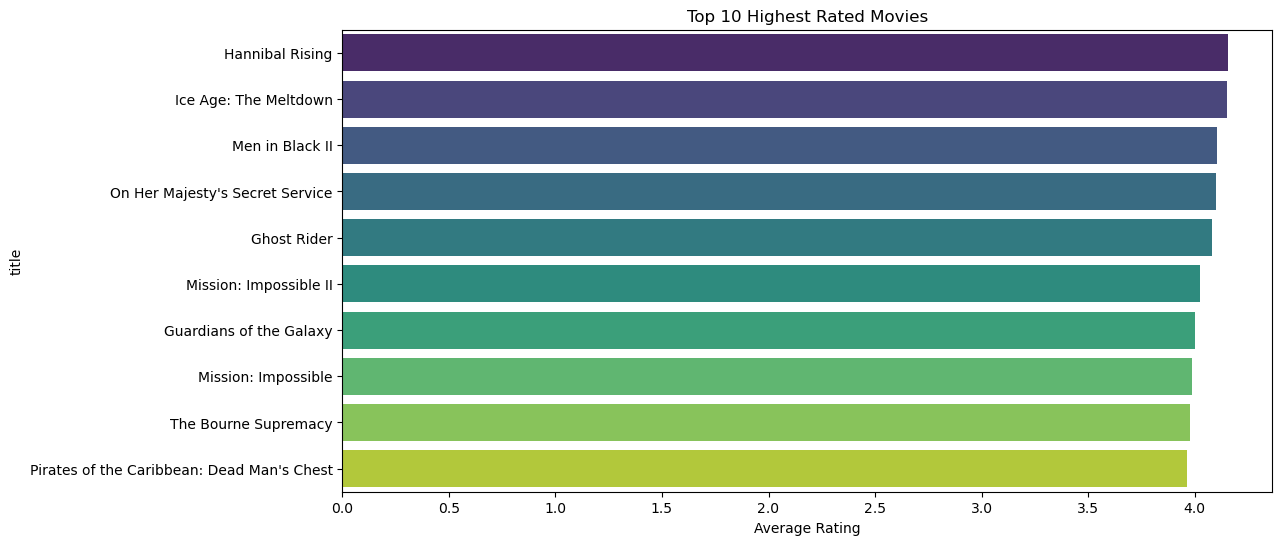

In [ ]:
# Calculate average ratings for each movie
average_ratings = merged_data.groupBy("title").agg({"rating": "avg"}).orderBy("avg(rating)", ascending=False).limit(10)

# Convert to Pandas DataFrame for plotting
average_ratings_pd = average_ratings.toPandas()

# Plot the horizontal bar chart for top-rated movies
plt.figure(figsize=(12, 6))
sns.barplot(x="avg(rating)", y=average_ratings_pd["title"], data=average_ratings_pd, palette="viridis", orient="h")
plt.title("Top 10 Highest Rated Movies")
plt.xlabel("Average Rating")
plt.show()

### Word Cloud

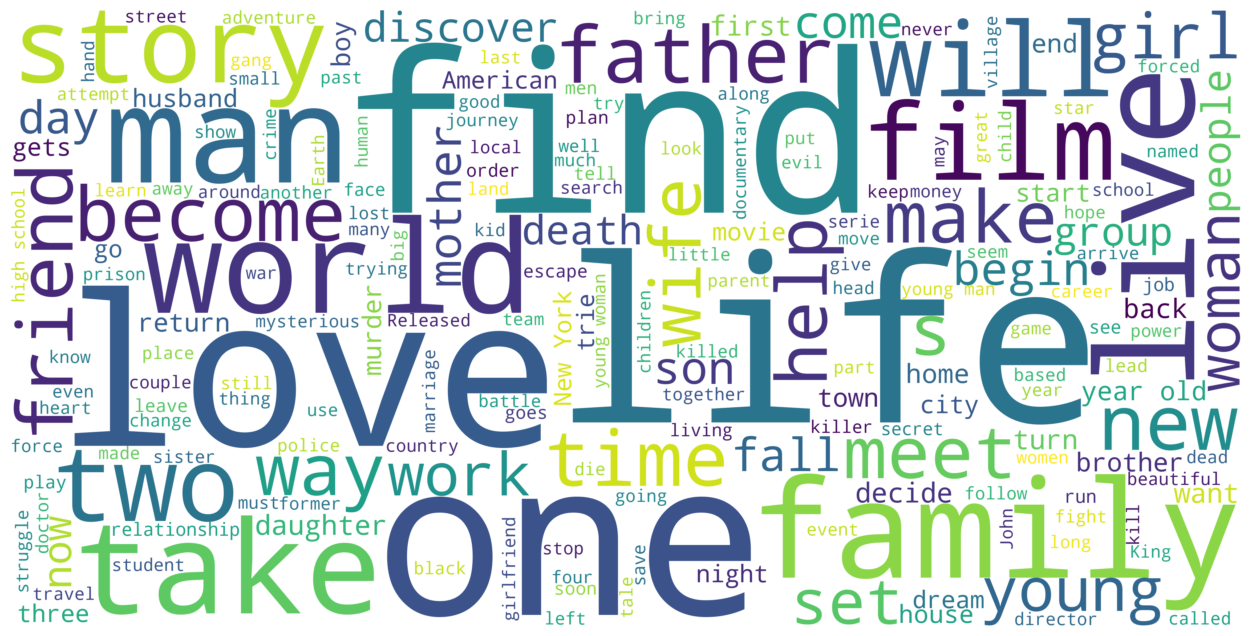

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from pyspark.sql.functions import col, concat_ws

# Convert 'title' and 'overview' columns to string type
movies_metadata = movies_metadata.withColumn('title', col('title').cast('string'))
movies_metadata = movies_metadata.withColumn('overview', col('overview').cast('string'))

# Concatenate 'title' and 'overview' columns into a single column
corpus_df = movies_metadata.select(concat_ws(' ', col('title'), col('overview')).alias('corpus'))

# Collect the data to the driver (potentially causing performance issues for large datasets)
corpus_list = [row.corpus for row in corpus_df.collect()]

# Join the strings into a single corpus
corpus = ' '.join(corpus_list)

# Create a WordCloud excluding common English stop words
title_wordcloud = WordCloud(stopwords=set(STOPWORDS), background_color='white', height=2000, width=4000).generate(corpus)

# Plot the WordCloud using a local Python environment
plt.figure(figsize=(16, 8))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
import ast


# Filter rows where 'belongs_to_collection' is not null
movies_metadata_fran = movies_metadata.filter(col('belongs_to_collection').isNotNull())

# Extract the 'name' from 'belongs_to_collection' using a UDF
def get_collection_name(x):
    try:
        return ast.literal_eval(x)['name'] if isinstance(x, str) else None
    except (ValueError, SyntaxError, TypeError):
        return None

get_collection_name_udf = F.udf(get_collection_name, StringType())
movies_metadata_fran = movies_metadata_fran.withColumn('belongs_to_collection', get_collection_name_udf('belongs_to_collection'))

# Filter rows where 'belongs_to_collection' is not null
movies_metadata_fran = movies_metadata_fran.filter(col('belongs_to_collection').isNotNull())

# Create a pivot table with additional columns including 'title'
fran_pivot = movies_metadata_fran.groupBy('belongs_to_collection', 'title').agg(
    F.mean('revenue').alias('mean'),
    F.sum('revenue').alias('sum'),
    F.count('revenue').alias('count'),
    F.min('revenue').alias('min'),
    F.max('revenue').alias('max')
)

# Sort and show the top 10 rows
fran_pivot = fran_pivot.sort('sum', ascending=False)
fran_pivot.show(10, truncate=False)

+-----------------------------------+--------------------------------------------+-------------+-------------+-----+----------+----------+
|belongs_to_collection              |title                                       |mean         |sum          |count|min       |max       |
+-----------------------------------+--------------------------------------------+-------------+-------------+-----+----------+----------+
|Avatar Collection                  |Avatar                                      |2.787965087E9|2.787965087E9|1    |2787965087|2787965087|
|Star Wars Collection               |Star Wars: The Force Awakens                |2.068223624E9|2.068223624E9|1    |2068223624|2068223624|
|The Avengers Collection            |The Avengers                                |1.51955791E9 |1.51955791E9 |1    |1519557910|1519557910|
|Jurassic Park Collection           |Jurassic World                              |1.51352881E9 |1.51352881E9 |1    |1513528810|1513528810|
|The Fast and the Furious C

## ALS Recommendation

In [ ]:
ratings_small = spark.read.csv("ratings_small.csv", header=True, inferSchema=True)

# Split the dataset into training and testing sets
(training, test) = ratings_small.randomSplit([0.8, 0.2])

# Check for and handle missing values
training = training.na.drop()
test = test.na.drop()

# Build the recommendation model using ALS
als = ALS(maxIter=20, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")

model = als.fit(training)

# Evaluate the model on the test set
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data = {rmse}")

# Generate movie recommendations for a given user
user_id = 1
user_unrated_movies = test.filter(col("userId") == user_id).select("movieId", "userId")

# Generate recommendations for unrated movies
recommendations = model.transform(user_unrated_movies)
recommendations.show()

Root Mean Squared Error (RMSE) on the test data = 0.9190769871701238


+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
|   1061|     1|  2.175837|
|   1287|     1|  2.711365|
|   1293|     1| 3.2624724|
|   1339|     1| 2.0790188|
|   2150|     1|  3.112053|
|   2455|     1|      2.72|
|   3671|     1|  2.980114|
+-------+------+----------+



In [ ]:
predictions.select("userId", "movieId", "rating", "prediction").show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   148|     29|   3.5| 4.4856453|
|   148|    185|   3.0| 3.2440128|
|   148|    904|   5.0| 4.5367966|
|   148|    934|   3.5| 3.9860313|
|   148|   1028|   5.0| 4.0551057|
|   148|   1136|   4.5| 4.4095373|
|   148|   1394|   4.5| 4.0912557|
|   148|   1449|   4.5|  4.083338|
|   148|   1617|   4.5|  4.156761|
|   148|   1653|   4.0|  3.981772|
|   148|   1676|   3.5| 3.0953403|
|   148|   1711|   4.0| 3.7397594|
|   148|   1923|   4.0| 3.5577745|
|   148|   2046|   4.5| 3.6619866|
|   148|   2706|   1.0| 3.2548347|
|   148|   3897|   4.5| 4.1450443|
|   148|   4226|   5.0| 4.3513145|
|   148|   4835|   4.0| 3.9198792|
|   148|   4896|   4.0| 3.8677578|
|   148|   5291|   5.0|  4.080274|
+------+-------+------+----------+
only showing top 20 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import functions as F

# Convert necessary columns to appropriate data types
merged_data = merged_data.withColumn("userId", merged_data["userId"].cast("int"))
merged_data = merged_data.withColumn("movieId", merged_data["movieId"].cast("int"))
merged_data = merged_data.withColumn("rating", merged_data["rating"].cast("float"))

# Create ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")

# Split the data into training and testing sets
(training, test) = merged_data.randomSplit([0.8, 0.2])

# Fit the model to the training data
model = als.fit(training)

# Generate predictions on the test data
predictions = model.transform(test)

# Evaluate the model using RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) = {rmse}")

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)

# Show the recommendations for a specific user (replace USER_ID with the actual user ID)
user_id = 8659
user_recommendations = userRecs.filter(F.col("userId") == user_id).select("recommendations.movieId").collect()[0][0]

# Display the recommended movies
recommended_movies = movies_metadata.filter(F.col("id").isin(user_recommendations))
recommended_movies.select("title", "genres", "release_date", "vote_average", "vote_count").show(truncate=False)


Root Mean Squared Error (RMSE) = 1.4650165950599872


+----------------------------------+------------------------------------------------------------------------------------------------------------------------------------+------------+------------+----------+
|title                             |genres                                                                                                                              |release_date|vote_average|vote_count|
+----------------------------------+------------------------------------------------------------------------------------------------------------------------------------+------------+------------+----------+
|Basic Instinct                    |[{'id': 53, 'name': 'Thriller'}, {'id': 9648, 'name': 'Mystery'}]                                                                   |1992-03-20  |6.5         |869       |
|Planet of the Apes                |[{'id': 878, 'name': 'Science Fiction'}, {'id': 12, 'name': 'Adventure'}, {'id': 18, 'name': 'Drama'}, {'id': 28, 'name': 'Action'}]|196

In [ ]:
recommended_movies_pd = recommended_movies.toPandas()

# Display the Pandas DataFrame
recommended_movies_pd

,adult,belongs_to_collection,budget,genres,homepage,id,original_language,overview,popularity,poster_path,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,return,year
0,False,"{'id': 86336, 'name': 'Basic Instinct Collecti...",49000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",https://www.sonymoviechannel.com/movies/basic-...,402,en,A police detective is in charge of the investi...,16.628427,/p1DHOfLFZmM567ePKfFNMV4mY92.jpg,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A brutal murder. A brilliant killer. A cop who...,Basic Instinct,False,6.5,869,7.202596,1992.0
1,False,"{'id': 1709, 'name': 'Planet of the Apes Origi...",5800000.0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://www.foxmovies.com/movies/planet-of-the-...,871,en,"An U.S. Spaceship lands on a desolate planet,...",17.784978,/lj3k2LU4LYpQA3gfJM3uqo7HCf7.jpg,...,112.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Somewhere in the Universe, there must be somet...",Planet of the Apes,False,7.5,958,5.757832,1968.0
2,False,"{'id': 2980, 'name': 'Ghostbusters Collection'...",30000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 14, 'nam...",http://www.ghostbusters.com/,620,en,"""After losing their academic posts at a presti...",hobgoblins and supernatural pests of all stri...,22.089729,...,295212467,107.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They ain't afraid of no ghost.,Ghostbusters,False,7.3,NaN,NaN
3,False,"{'id': 645, 'name': 'James Bond Collection', '...",2000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",http://www.mgm.com/view/movie/717/From-Russia-...,657,en,Agent 007 is back in the second installment of...,12.536729,/fvIG285JwenrV1K6kVASi1TECJ0.jpg,...,115.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The world's masters of murder pull out all the...,From Russia with Love,False,6.9,773,39.449382,1963.0
4,False,"{'id': 31562, 'name': 'The Bourne Collection',...",70000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",http://www.universalstudiosentertainment.com/t...,2503,en,Bourne is brought out of hiding once again by ...,18.173269,/fHho6JYYY0nRcETWSoeI19iZsNF.jpg,...,115.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Remember everything. Forgive nothing.,The Bourne Ultimatum,False,7.3,2938,6.326059,2007.0
5,False,"{'id': 52984, 'name': 'National Treasure Colle...",130000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://disney.go.com/disneypictures/nationaltr...,6637,en,Benjamin Franklin Gates and Dr. Abigail Chase ...,12.854373,/sHr05tz70r7y8A6XrdCBsHPK7tF.jpg,...,124.0,"[{'iso_639_1': 'la', 'name': 'Latin'}, {'iso_6...",Released,The Greatest Adventure History Has Ever Revealed,National Treasure: Book of Secrets,False,6.1,1782,3.518178,2007.0
6,False,"{'id': 251383, 'name': 'The Gamers Collection'...",NaN,"[{'id': 12, 'name': 'Adventure'}, {'id': 35, '...",http://deadgentlemen.com/projects/the-gamers/t...,26235,en,All Lodge wants is for his gaming group to fin...,0.623316,/mndi25H3RJt9s7ay5UBrEfU5gUs.jpg,...,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They'll be taking a few liberties with the rules.,The Gamers: Dorkness Rising,False,7.6,14,NaN,2008.0
7,False,"{'id': 119581, 'name': 'Elite Squad Collection...",NaN,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://www.tropa2.com.br/,47931,pt,After a bloody invasion of the BOPE in the Hig...,12.334357,/65Uy9xucPOAZDKa54RlojVyP24k.jpg,...,115.0,"[{'iso_639_1': 'pt', 'name': 'Português'}]",Released,The masterminds of the organized crime in Rio,Elite Squad: The Enemy Within,False,7.5,477,NaN,2010.0
8,False,"{'id': 393379, 'name': 'The Huntsman Collectio...",170000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://www.snowwhiteandthehuntsman.com/,58595,en,"After the Evil Queen marries the King, she per...",18.751554,/40iabcM7KQLJzmO8yGm8AvUbxZR.jpg,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Fairytale is Ove